## Homework 3: Financial Ratio Quantile Strategies
### FINM 33150 (Winter 2025) - Quantitative Trading Strategies
#### NAME: Arturo Charleston
#### Student ID: 12449584

### Introduction
In this notebook we implement a quantile trading strategy. We construct the three financial ratios. 
1. Debt to Market Cap
2. Return on Investment
3. Price to Earnings

To construct the financial ratios, we use data from ZACKS Investment Research which reports the quarterly fundamental data found in the 10-Q reported by public companies. 
However, I use daily financial ratios to construct our portfolio. To do this, we assume that the only variable that change on a daily basis is the price, and thus the market capitalization. Then, the financial ratios are adjusted accordingly. 
I consider the financial ratio until the moment that is filled, instead of the date to which the data corresponds to avoid lookahead bias.

I use the three financial ratios, and a weighted average of the Z-score of the financial ratios with equal and unequal weights. We use a Z-score to avoid the problem of units given that the three financial ratios are in different units. Then, I use these financial ratios Z-Scores to compute the equally weighted average, and an unequal weighted average to place more weight on the ratio that we found to have a positive return. 

In [1]:
# PACKAGES
import os
import nasdaqdatalink
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import quandl
import functools
import warnings

# Global Options
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

# Set directory
home_directory = "/Users/charleston/Downloads/git_repositories/finm-qts-2025"
os.chdir(home_directory)

# Set keys
from config import QUANDL_KEY
quandl_keys = QUANDL_KEY
nasdaqdatalink.ApiConfig.api_key = quandl_keys
quandl.ApiConfig.api_key = quandl_keys

# Set dates
trading_start_date = pd.to_datetime('2017-01-01')
trading_end_date = pd.to_datetime('2024-06-30')

# Set random seed
np.random.seed(12449584)  # For reproducibility


In [2]:
# FUNCTIONS
@functools.lru_cache(maxsize=1600)
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(home_directory, "data", "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=quandl_keys, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"

@functools.lru_cache(maxsize=1600)
def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )


def forward_fill_columns(df, columns_to_forward_fill, filing_col='filing_date', date_col='date'):
    """
    Forward-fills selected columns using filing dates in a vectorized manner.
    
    Parameters:
    - df: DataFrame with financial data
    - columns_to_forward_fill: List of columns to forward fill
    - filing_col: Column name containing filing dates (default is 'filing_date')
    - date_col: Column name containing dates (default is 'date')
    
    Returns:
    - df: DataFrame with forward-filled columns
    """

    df = df.copy()  # Avoid modifying the original DataFrame

    # Ensure date columns are in datetime format for proper comparison
    df[filing_col] = pd.to_datetime(df[filing_col])
    df[date_col] = pd.to_datetime(df[date_col])
    
    for col in columns_to_forward_fill:
        # Step 1: Create a column that keeps the value only at filing dates
        df[f'{col}_temp'] = df.where(df[filing_col].notna(), np.nan)[col]
        
        # Step 2: Forward-fill these values down the entire DataFrame
        df[f'{col}_temp'] = df[f'{col}_temp'].ffill()

        # Step 3: Ensure values only apply to rows where `date_col` > `filing_col`
        df[f'{col}_forward'] = np.where(
            (df[filing_col].notna()) & (df[date_col] > df[filing_col]),
            df[f'{col}_temp'],
            np.nan
        )

        # Step 4: Forward-fill within each group defined by `filing_col`
        df[f'{col}_forward'] = df[f'{col}_forward'].ffill()

        # Drop temporary column
        df.drop(columns=[f'{col}_temp'], inplace=True)
    
    return df

def compute_custom_metric(data, new_col_name, metrics, weights=None):
    """
    Compute a custom metric as a weighted sum of multiple metrics after applying Z-score normalization.

    Parameters:
    - data: DataFrame with columns ['ticker', 'date', metrics].
    - new_col_name: Name for the new computed column.
    - metrics: List of metrics to combine.
    - weights: List of weights for each metric. If None, equal weights are used.

    Returns:
    - DataFrame with a new column named `new_col_name` (original metrics remain unchanged).
    """
    if weights is None:
        weights = np.ones(len(metrics)) / len(metrics)  # Equal weighting

    data = data.copy()
    
    # Compute Z-score normalized values for selected metrics without modifying original data
    normalized_values = [(data[m] - data[m].mean()) / data[m].std() for m in metrics]
    
    # Compute weighted sum of normalized metrics
    data[new_col_name] = sum(w * norm_m for w, norm_m in zip(weights, normalized_values))
    
    return data


def quantiles_signals(data, metric, freq='M', top_q=0.9, bottom_q=0.1, use_changes=False, lookback_window=14):
    """
    Compute trading signals based on quantiles of a given metric.

    Parameters:
    - data: DataFrame with columns ['ticker', 'date', metric].
    - metric: The ratio used for ranking.
    - freq: Rebalancing frequency ('W' for weekly, 'M' for monthly).
    - top_q, bottom_q: Quantiles for short and long positions.
    - use_changes: If True, use changes over `lookback` days.
    - lookback: Number of days for computing changes.

    Returns:
    - DataFrame with trading signals (+1 long, -1 short, 0 neutral).
    """
    data = data[['ticker', 'date', 'adj_close', metric]].copy()
    if use_changes:
        data[metric] = data.groupby('ticker')[metric].diff(lookback_window)

    rebalance_dates = data.resample(freq, on='date').last().index.to_numpy()
    data = data[data['date'].isin(rebalance_dates)]

    quantiles = data.groupby('date')[metric].quantile([bottom_q, top_q]).unstack()
    
    # Assign signals

    data['signal'] = np.select(
        [data[metric] <= data['date'].map(quantiles[bottom_q]),
         data[metric] >= data['date'].map(quantiles[top_q])],
        [1, -1], 
        default=0
    )

    return data

def quantiles_backtest(
    signals: pd.DataFrame,
    original_data: pd.DataFrame,
    initial_capital: float = None,            # If None, set to 10x first rebalance period's gross notional
    annual_funding_rate: float = 0.02,        # 2% annual
    short_cost_bps: float = 100.0,            # 1% short cost
    leverage_factor: float = 1.0,             # Leverage factor 50 to 1, common with repos
    trading_days: int = 252,                  # Trading days in a year
    sizing_top: float = 1.0,                  # Multiplier for top quantile
    sizing_bottom: float = 1.0,               # Multiplier for bottom quantile
    rf_rate: pd.Series = None,                # LIBOR risk-free rate (daily)
    spy_returns: pd.Series = None             # SPY returns as the market benchmark
):
    """
    Execute a backtest using quantile-based trading signals.
    
    Parameters:
    - signals: DataFrame with ['ticker', 'date', 'signal'].
    - original_data: DataFrame with ['ticker', 'date', 'adj_close'].
    - initial_capital: Starting capital for the portfolio. If None, set to 10x first rebalance period's gross notional.
    - annual_funding_rate: Annual funding rate for long positions.
    - short_cost_bps: Basis points cost for short positions.
    - leverage_factor: Leverage applied to the portfolio.
    - trading_days: Number of trading days in a year.
    - rf_rate: Pandas Series of LIBOR risk-free rate (daily).
    - spy_returns: Pandas Series of SPY daily returns as a market benchmark.

    Returns:
    - results: DataFrame containing PortfolioValue, DailyPnL, DailyReturn, and Drawdown.
    - performance: Series with summary performance metrics (including VaR, CVaR, Downside Beta).
    """
    
    # Ensure 'date' columns are datetime
    signals['date'] = pd.to_datetime(signals['date'])
    original_data['date'] = pd.to_datetime(original_data['date'])
    
    # Sort data by date and ticker
    signals = signals.sort_values(['date', 'ticker']).reset_index(drop=True)
    original_data = original_data.sort_values(['date', 'ticker']).reset_index(drop=True)
    
    # Calculate daily returns
    original_data['daily_return'] = original_data.groupby('ticker')['adj_close'].pct_change().fillna(0)
    
    # Pivot original_data for easier access: rows are dates, columns are tickers
    returns_pivot = original_data.pivot(index='date', columns='ticker', values='daily_return').fillna(0)
    
    # Get all unique dates sorted
    all_dates = returns_pivot.index.sort_values()
    
    # Determine rebalance dates from signals
    rebalance_dates = signals['date'].unique()
    
    # Set initial capital
    if initial_capital is None:
        first_rebalance_signals = signals[signals['date'] == rebalance_dates[0]]
        gross_notional = first_rebalance_signals['signal'].abs().sum()
        initial_capital = 10 * gross_notional
    
    # Initialize portfolio tracking
    portfolio_value = pd.Series(index=all_dates, dtype=float)
    daily_pnl = pd.Series(index=all_dates, dtype=float)
    daily_return = pd.Series(index=all_dates, dtype=float)
    
    # Set initial values
    first_date = all_dates[0]
    portfolio_value[first_date] = initial_capital
    daily_pnl[first_date] = 0.0
    daily_return[first_date] = 0.0
    
    # Initialize current positions as an empty dictionary
    current_positions = {}
    
    # Calculate repo rate
    repo_rate = annual_funding_rate - 0.01  # 100 bps = 1%
    
    for current_date in all_dates[1:]:
        prev_date = all_dates[all_dates.get_loc(current_date) - 1]
        current_capital = portfolio_value[prev_date]
        
        # Check if today is a rebalance date
        if current_date in rebalance_dates:
            todays_signals = signals[signals['date'] == current_date]
            
            # Reset current positions
            current_positions = {}
            
            # Assign positions based on signals
            for _, row in todays_signals.iterrows():
                ticker = row['ticker']
                signal = row['signal']
                
                if signal == 1:  # Long position
                    current_positions[ticker] = signal * sizing_top  # Apply bottom multiplier
                elif signal == -1:  # Short position
                    current_positions[ticker] = signal * sizing_bottom  # Apply top multiplier
                # Ignore neutral positions (0)
        
        # If no active positions, carry forward the capital
        if not current_positions:
            daily_pnl[current_date] = 0.0
            daily_return[current_date] = 0.0
            portfolio_value[current_date] = current_capital
            continue
        
        # Calculate total notional based on leverage
        notional = current_capital * leverage_factor
        
        # Calculate weights: equal weight based on absolute signals
        total_abs_signal = sum(abs(sig) for sig in current_positions.values())
        if total_abs_signal == 0:
            weights = {ticker: 0 for ticker in current_positions}
        else:
            weights = {ticker: sig / total_abs_signal for ticker, sig in current_positions.items()}
        
        # Calculate position notionals
        position_notionals = {ticker: weights[ticker] * notional for ticker in current_positions}
        
        # Get today's returns for the positions
        todays_returns = returns_pivot.loc[current_date, list(current_positions.keys())]
        
        # Calculate PnL
        pnl = (todays_returns * pd.Series(position_notionals)).sum()
        
        # Calculate funding costs
        funding_cost = 0.0
        for ticker, pos_notional in position_notionals.items():
            if pos_notional > 0:
                # Long position: use repo rate
                cost = (repo_rate / trading_days) * pos_notional
            else:
                # Short position: use funding rate + short cost
                cost = ((annual_funding_rate + short_cost_bps / 10000) / trading_days) * abs(pos_notional)
            funding_cost += cost
        
        # Net PnL
        net_pnl = pnl - funding_cost
        
        # Update portfolio value
        portfolio_value[current_date] = current_capital + net_pnl
        
        # Record PnL and return
        daily_pnl[current_date] = net_pnl
        daily_return[current_date] = net_pnl / current_capital
    
    # Fill initial portfolio value if not set
    portfolio_value.fillna(method='ffill', inplace=True)
    daily_pnl.fillna(0.0, inplace=True)
    daily_return.fillna(0.0, inplace=True)
    
    # Calculate Drawdown
    running_max = portfolio_value.cummax()
    drawdown = (portfolio_value - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Compile results
    results = pd.DataFrame({
        'PortfolioValue': portfolio_value,
        'DailyPnL': daily_pnl,
        'DailyReturn': daily_return,
        'Drawdown': drawdown
    })
    
    # Ensure alignment of risk-free rate & SPY with portfolio
    if rf_rate is not None:
        rf_rate.index = pd.to_datetime(rf_rate.index)  # Ensure datetime index
        rf_rate = rf_rate.reindex(results.index, method='ffill')
        excess_returns = results['DailyReturn'] - rf_rate
    else:
        excess_returns = results['DailyReturn']

    # If SPY returns are provided, use them; otherwise, use market average
    if spy_returns is not None:
        spy_returns.index = pd.to_datetime(spy_returns.index)  # Ensure datetime index
        spy_returns = spy_returns.reindex(results.index, method='ffill')
    else:
        spy_returns = returns_pivot.mean(axis=1)  # Use market average if SPY is missing

    beta = excess_returns.cov(spy_returns) / spy_returns.var()
    downside_beta = excess_returns[spy_returns < 0].cov(spy_returns[spy_returns < 0]) / spy_returns[spy_returns < 0].var()

    skewness = excess_returns.skew()
    excess_kurtosis = excess_returns.kurtosis()
    var_95 = excess_returns.quantile(0.05)  # 5% left tail (negative)
    cvar_95 = excess_returns[excess_returns <= var_95].mean()
    var_vol_ratio = abs(var_95) / (excess_returns.std() * np.sqrt(trading_days))
    
    downside_std = excess_returns[excess_returns < 0].std() * np.sqrt(trading_days)
    sortino_ratio = excess_returns.mean() * trading_days / downside_std if downside_std > 0 else np.nan

    treynor_ratio = excess_returns.mean() * trading_days / beta if beta != 0 else np.nan

    performance = pd.Series({
        'Total Return': (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1.0,
        'Annualized Return': excess_returns.mean() * trading_days,
        'Volatility': excess_returns.std() * np.sqrt(trading_days),
        'Sharpe Ratio': excess_returns.mean() / excess_returns.std() * np.sqrt(trading_days),
        'Max Drawdown': max_drawdown,
        'Beta': beta,
        'Downside Beta': downside_beta,
        'Skewness': skewness,
        'Excess Kurtosis': excess_kurtosis,
        '95% VaR': var_95,
        '95% CVaR': cvar_95,
        'VaR/Volatility': var_vol_ratio,
        'Sortino Ratio': sortino_ratio,
        'Treynor Ratio': treynor_ratio
    })

    return results, performance


In [3]:
# Download data
eod_prices = fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=True)
ZACKS_FC = fetch_quandl_table('ZACKS/FC', avoid_download=True)
ZACKS_FR = fetch_quandl_table('ZACKS/FR', avoid_download=True)
ZACKS_MKTV = fetch_quandl_table('ZACKS/MKTV', avoid_download=True)
ZACKS_SHRS = fetch_quandl_table('ZACKS/SHRS', avoid_download=True)

Skipping any possible download of QUOTEMEDIA/PRICES
Skipping any possible download of ZACKS/FC
Skipping any possible download of ZACKS/FR
Skipping any possible download of ZACKS/MKTV
Skipping any possible download of ZACKS/SHRS


## Data Filtering
Before creating our selected financial ratios, I perform some data cleaning to have it in the desired format. The cleaning steps are detailed below

- Filter the ZACKS tables to contain information after 2016-01-01 so we can capture the information that was reported up to one-year before the trading date. That is, we exclude any information that is older than one year of our trading date. 
- I restrict the dataset to the trading dates (2017-01-01 to 2024-06-30), and keep the tickers that have an end of data price in all the trading days (1844). We are left with 4844 tickers.
- Then, I merge the prices data with ZACKS MKTV to get the quarterly Market Capitalization. And I filter to keep only those tickets with a market cap that never dips below 1 Billion dollars. This reduces our sample of tickers to 1279
- I merge the prices data with ZACKS FR database to get the debt to market capitalization. And we filter to those that this ratio is greater than 0.1 (10%) in some period in time. This reduces our sample of tickers to 1214
- The last filtering step, is to remove stocks in the automotive, financial, or insurance sector. We retrieve this data from ZACKS FC, and this left us with an universe of investable tickers of 897.

In [4]:
data_tables = [ZACKS_FC, ZACKS_FR, ZACKS_MKTV, ZACKS_SHRS]

# Filter to initial date to save memory
for i, table_name in enumerate(['ZACKS_FC', 'ZACKS_FR', 'ZACKS_MKTV', 'ZACKS_SHRS']):
    table = data_tables[i]
    if 'per_end_date' in table.columns:
        table['per_end_date'] = pd.to_datetime(table['per_end_date'])
        table = table[(table['per_type'] == 'Q') & (table['per_end_date'] >= '2016-01-01')]


In [5]:
# TICKERS To keep
# End of day prices cleaning
start_date = '2016-01-01' # One year before for better merging with ZACKS data
end_date = '2024-12-31' # End of 2024 to have the latest data
eod_prices.query('date >= @start_date and date <= @end_date', inplace=True)
eod_prices['date'] = pd.to_datetime(eod_prices['date'])
eod_prices = eod_prices[['ticker', 'date', 'adj_close']]

# Valid tickers
eod_restricted = eod_prices[(eod_prices['date'] >= trading_start_date) & (eod_prices['date'] <= trading_end_date)]
num_dates = eod_restricted['date'].nunique()
valid_tickers_list = eod_restricted.groupby('ticker').filter(lambda x: x['date'].nunique() == num_dates)
valid_tickers_list = valid_tickers_list['ticker'].unique()

# Restrict the data to the valid tickers
valid_tickers = eod_prices[eod_prices['ticker'].isin(valid_tickers_list)]
print(f"Number of valid tickers: {valid_tickers['ticker'].nunique()}")

Number of valid tickers: 4844


In [6]:
# Sort the ZACKS_MKTV data by ticker and per_end_date
ZACKS_MKTV = ZACKS_MKTV.sort_values(by=['ticker', 'per_end_date'])

# Now perform a left merge
valid_tickers_mkt = pd.merge_asof(
    valid_tickers.sort_values(by='date'), 
    ZACKS_MKTV[['ticker', 'per_end_date', 'mkt_val']].sort_values(by='per_end_date'), 
    by='ticker', 
    left_on='date', 
    right_on='per_end_date', 
    direction='backward',
    suffixes=('', '_mktv')
).sort_values(["ticker", "date"])

min_mtk_cap = 1_000 # Mkt is already in thousands
valid_tickers_mkt = valid_tickers_mkt.groupby('ticker').filter(lambda x: x['mkt_val'].min() > min_mtk_cap)

# Get the number of valid tickers
print(f"Number of valid tickers: {valid_tickers_mkt['ticker'].nunique()}")



Number of valid tickers: 1279


In [7]:
# Remove observations in which the total debt to total equity ratio is less than 0.1
# Sort the ZACKS_FR data by ticker and per_end_date
ZACKS_FR = ZACKS_FR.sort_values(by=['ticker', 'per_end_date'])

# Now perform a left merge
valid_tickers_mkt_debt = pd.merge_asof(
    valid_tickers_mkt.sort_values(by='date'), 
    ZACKS_FR[['ticker','tot_debt_tot_equity', 'ret_invst', 'per_end_date']].sort_values(by='per_end_date'), 
    by='ticker', 
    left_on='date', 
    right_on='per_end_date', 
    direction='backward',
    suffixes=('', '_fr')
).sort_values(["ticker", "date"])

valid_tickers_mkt_debt = valid_tickers_mkt_debt.groupby('ticker').filter(lambda x: x['tot_debt_tot_equity'].max() > 0.1)

#valid_tickers_mkt_debt.drop(columns=['per_end_date_x', 'per_end_date_y'], inplace=True)

print(f"Number of tickers: {valid_tickers_mkt_debt['ticker'].nunique()}")


Number of tickers: 1214


In [8]:
# Restrict to tickers that are NOT in the automotive, financial, or insurance sector (sectors 5, 13 from zacks_sector_code)
valid_tickers_mkt_debt = valid_tickers_mkt_debt[
    valid_tickers_mkt_debt['ticker'].isin(
        ZACKS_FC[~ZACKS_FC["zacks_sector_code"].isin([5, 13])]['ticker'].unique()
    )
]

print(f"Number of tickers: {valid_tickers_mkt_debt['ticker'].nunique()}")


Number of tickers: 897


## Data preparing
To prepare our data for the quantile trading strategy, we perform some additional calculations and data preparing

- I merge the quarterly number of shares outstanding from ZACKS SHRS to perform market capitalization calculations
- Then, I merge the debt, earnings per share, and filing date from ZACKS FC for accurate filing date imputing.
- Based on the columns required, the filing date, and the per end date of the accounting variable, I forward fill the trading data. For example, talking about market capitalization, if the per end date was 2021-06-31, the data correspond to the second quarter of 2021. However, the data is not reported the same date as it corresponds, but in a later date given by filing date. In this case, if filling date is 2021-07-25, then we would consider the new market capitalization as a value until 2021-07-26 because that value was unknown until that day. 
- Based on the forward filled variables, we calculate the financial ratios used for trading on a daily basis, using the end of day close prices, and the quarterly reported accounting variables. We use them to calculate
  1. Debt To Market-Cap
  2. Return On Investment
  3. Price to Earnings

- In addition, I construct a Z-Score of the financial ratios, and use it to construct two weighted average using the financial ratios. I use a Z-Score because the financial ratios have different units, so I standarize the metrics for easy aggregation. I use an equally weighted average, and an unequal weighted average to place more weight on Debt To Market Cap given that we found a positive return on the portfolio based on that metric.

- As a final step, out of the 897 remaining ticker, I select a few tickers included in the HW assignment to confirm that my process was correct, and select 200-selected tickers randomly, and set a seed for reproducibility purposes. From that delimited sample, I keep the financial ratios, and the prices columns. 

In [9]:
FC_columns = ['ticker', 'net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps', 'filing_date', 'per_end_date']

financial_ratios = pd.merge_asof(
    valid_tickers_mkt_debt.sort_values(by='date'), 
    ZACKS_SHRS[['ticker', 'per_end_date', 'shares_out']].sort_values(by='per_end_date'), 
    by='ticker', 
    left_on='date', 
    right_on='per_end_date', 
    direction='backward',
    suffixes=('', '_shrs')
).sort_values(["ticker", "date"])

financial_ratios = pd.merge_asof(
    financial_ratios.sort_values(by='date'), 
    ZACKS_FC[FC_columns].sort_values(by='per_end_date'), 
    by='ticker', 
    left_on='date', 
    right_on='per_end_date', 
    direction='backward',
    suffixes=('', '_fc')
).sort_values(["ticker", "date"])

In [10]:
# Generalized forward-fill for selected columns
columns_to_forward_fill = [
    'tot_debt_tot_equity', 'ret_invst', 'mkt_val', 'net_lterm_debt', 
    'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps', 'shares_out'
]

trading_data = forward_fill_columns(financial_ratios, columns_to_forward_fill)

### Sanity Check
Make sure that the Waste Management WM data fits with the SEC reports in 6.0.1. 

In [11]:
# Filter the trading_data DataFrame for WM and the specified per_end_date values
WM = trading_data[trading_data['ticker'] == 'WM']
dates_per_end = ["2023-06-30", "2023-09-30", "2023-12-31", "2024-03-31", "2024-06-30", "2024-09-30"]
WM[WM['per_end_date'].isin(dates_per_end)].drop_duplicates(subset=['per_end_date']).T.head(15)


,1687997,1744936,1801665,1856136,1912669,1968998
ticker,WM,WM,WM,WM,WM,WM
date,2023-06-30 00:00:00,2023-10-02 00:00:00,2024-01-02 00:00:00,2024-04-01 00:00:00,2024-07-01 00:00:00,2024-09-30 00:00:00
adj_close,170.14506,149.01636,177.72898,211.43155,207.90620,206.90161
per_end_date,2023-06-30 00:00:00,2023-09-30 00:00:00,2023-12-31 00:00:00,2024-03-31 00:00:00,2024-06-30 00:00:00,2024-09-30 00:00:00
mkt_val,70245.41000,61399.09000,72137.08000,85490.86000,85616.50000,83323.49000
tot_debt_tot_equity,2.21820,2.21500,2.35340,2.27440,2.24710,2.08890
ret_invst,2.81410,2.99560,9.98640,3.09540,2.83900,3.17340
per_end_date_fr,2023-06-30 00:00:00,2023-09-30 00:00:00,2023-12-31 00:00:00,2024-03-31 00:00:00,2024-06-30 00:00:00,2024-09-30 00:00:00
per_end_date_shrs,2023-06-30 00:00:00,2023-09-30 00:00:00,2023-12-31 00:00:00,2024-03-31 00:00:00,2024-06-30 00:00:00,2024-09-30 00:00:00
shares_out,405.06000,402.77000,402.77000,401.08000,401.32000,401.37000


# Calculate financial ratios

- The ZACKS fundamental data includes quarterly information on the financial ratios. 
- The EOD database from contains daily end of day prices
- Combining this information, we can generate a daily time series of our financial ratios
- To calculate the financial ratios, and to avoid lookahead bias, I consider the 'forward' information. That is, I consider the information only when it was reported, and not the quarter to which it belongs. I use the reported date because otherwise we would be generating trading strategies based on information that was not available at the moment of trading.

In [12]:
# TO FIX IT YOU NEED TO FIND THE PRICE OF THE STOCK AT THE PER_END_DATE
# Select relevant columns
trading_data = trading_data[['ticker', 'date', 'adj_close', 'per_end_date', 'filing_date'] + 
                            [col + '_forward' for col in columns_to_forward_fill]]

# Market capitalization calculation
trading_data['mkt_cap'] = trading_data['adj_close'] * trading_data['shares_out_forward']

# Total debt calculation
trading_data['debt_constant'] = trading_data['tot_debt_tot_equity_forward'] * trading_data['mkt_val_forward']

# Debt-to-market-cap ratio
trading_data['debt_to_mkt_cap'] = trading_data['debt_constant'] / trading_data['mkt_cap']

# Determine final debt value
trading_data['debt_final'] = trading_data.apply(
    lambda row: row['net_lterm_debt_forward'] if pd.notna(row['net_lterm_debt_forward']) 
    else (row['tot_lterm_debt_forward'] if pd.notna(row['tot_lterm_debt_forward']) else 0.0), 
    axis=1
)

# Calculate return on investment
trading_data['income'] = trading_data['ret_invst_forward'] * (trading_data['mkt_val_forward'] + trading_data['debt_final'])
trading_data['return_on_inv'] = trading_data['income'] / (trading_data['mkt_cap'] + trading_data['debt_final'])

# Earnings per share (EPS) handling
trading_data['eps'] = trading_data['eps_diluted_net_forward'].fillna(trading_data['basic_net_eps_forward'])
trading_data['eps'] = trading_data['eps'].apply(lambda x: max(x, 0.001))  # Prevent negative EPS values

# Price-to-earnings ratio
trading_data['price_to_earnings'] = trading_data['adj_close'] / trading_data['eps']

# Create the composite metrics

# Equal weights
trading_data = compute_custom_metric(trading_data, 'equal_weight_signal', ['price_to_earnings', 'return_on_inv', 'debt_to_mkt_cap'])

# Custom weights
trading_data = compute_custom_metric(trading_data, 'weighted_DtM_PE_signal', ['debt_to_mkt_cap', 'price_to_earnings'], weights=[0.7, 0.3])


### Sanity Check
- Make sure that the Waste Management WM data fits with the ratios reported in 6.0.2. 

In [13]:
WM = trading_data[trading_data['ticker'] == 'WM']
dates = ["2022-10-26", "2022-10-27", "2022-12-30", "2023-01-03", "2023-02-07", "2023-02-08", "2023-03-31", "2023-04-03", "2023-04-27", "2023-04-28", "2023-06-30", "2023-07-03", "2023-07-26", "2023-07-27", "2023-09-29", "2023-10-02", "2023-10-25", "2023-10-26", "2023-12-29", "2024-01-02", "2024-02-13", "2024-02-14", "2024-03-28", "2024-04-01", "2024-04-25", "2024-04-26", "2024-06-28", "2024-07-01", "2024-07-25", "2024-07-26"]
WM[WM['date'].isin(dates)][['date', 'debt_to_mkt_cap', 'return_on_inv', 'price_to_earnings']]

,date,debt_to_mkt_cap,return_on_inv,price_to_earnings
1536368,2022-10-26,1.95979,2.72903,109.89646
1536595,2022-10-27,2.09549,3.20612,99.56907
1576896,2022-12-30,2.10630,3.22253,99.05810
1577079,2023-01-03,2.10429,3.21948,99.15281
1598923,2023-02-07,2.18355,3.33977,95.55368
1599779,2023-02-08,2.33454,2.49105,121.23607
1632130,2023-03-31,2.14843,2.29651,131.73821
1632936,2023-04-03,2.13925,2.28690,132.30337
1647814,2023-04-27,2.16890,2.31794,130.49486
1649370,2023-04-28,2.27085,2.44992,124.78211


### Randomly select 200 tickers out of our original sample of the 897 tickers.

In [14]:
# Out of the 897 tickers, pick randomly 200 of those. 
# AMZN, CAT, FLEX, POOL, SUN, WYNN, and WM must be in the sample
n_tickers = 200
specified_tickers = ['AMZN', 'CAT', 'FLEX', 'POOL', 'SUN', 'WYNN', 'WM']
remaining_tickers = np.setdiff1d(trading_data['ticker'].unique(), specified_tickers)
selected_tickers = np.concatenate([specified_tickers, np.random.choice(remaining_tickers, n_tickers - len(specified_tickers), replace=False)])
trading_ratios = trading_data[trading_data['ticker'].isin(selected_tickers)]
trading_ratios = trading_ratios[['ticker', 'date', 'adj_close', 'per_end_date', 'filing_date', 'debt_to_mkt_cap', 'return_on_inv', 'price_to_earnings', 'equal_weight_signal', 'weighted_DtM_PE_signal']]

trading_ratios = trading_ratios[(trading_ratios['date'] >= trading_start_date) & (trading_ratios['date'] <= trading_end_date)]

## Trading Strategy

- I perform different classifications of the quantiles, varying the frequency at which we rebalance the long and short quantiles.
1. I rank the quantiles and create my portfolio using monthly quantiles 
2. I also try with a weekly rebalance 
3. I consider changes in the ratios instead of using the ratios themselves

- I present different strategies derived from these quantiles. 
1. I include the standard long-short portfolio, where we go long on the top decile and short on the bottom decile. 
2. I present a modified portfolio going long 2.5x the top decile, and short 0.5 times the bottom decile. 
3. I test a leverage portfolio and compare it with the returns of the other strategies

- Performance metrics
1. I read the LIBOR-SOFR data to calculate the risk free rate which I use to calculate the Sharpe Ratio and the excess returns
2. I get the SP500 data from QUANDL EOD database, and calculate the daily SP500 returns given by ETF SPY to calculate Beta, Downside Beta, Sortino and Treynor Ratio
3. I also calculate standard performance metrics such as Annualized Return, Volatility, Sharpe Ratio, Maximum Drawdown, VaR, CVaR, Skewness, Kurtosis

As I show below, these performance metrics are really important to compare the performance of the different strategies. 


In [15]:
# Get the LIBOR-SOFR for the risk free rate
rf_rate = pd.read_csv('./data/FINM33150_Interp_LIBOR_SOFR_to_2025.tab', sep='\t', parse_dates=True, index_col=0)
rf_rate.columns = ['libor']
rf_rate['libor'] = (rf_rate['libor'] / 100) / 252 # Convert to daily rate
rf_rate = rf_rate.loc[trading_start_date:trading_end_date].fillna(method='ffill')

# Get SPY data to calculate the market Beta
spy = eod_prices[eod_prices['ticker'] == 'SPY']
spy.sort_values(by='date', inplace=True)
spy['daily_return'] = spy['adj_close'].pct_change()
spy = spy[(spy['date'] >= trading_start_date) & (spy['date'] <= trading_end_date)]
spy.set_index('date', inplace=True)


In [16]:
window = 28

# Monthly Resample
signals_PE = quantiles_signals(trading_ratios, 'price_to_earnings', freq='M', top_q=0.9, bottom_q=0.1, use_changes=False)
signals_DtM = quantiles_signals(trading_ratios, 'return_on_inv', freq='M', top_q=0.9, bottom_q=0.1, use_changes=False)
signals_ROI = quantiles_signals(trading_ratios, 'debt_to_mkt_cap', freq='M', top_q=0.9, bottom_q=0.1, use_changes=False)
signals_equal_weight = quantiles_signals(trading_ratios, 'equal_weight_signal', freq='M', top_q=0.9, bottom_q=0.1, use_changes=False)
signals_weighted_DtM_PE = quantiles_signals(trading_ratios, 'weighted_DtM_PE_signal', freq='M', top_q=0.9, bottom_q=0.1, use_changes=False)

# Weekly Resample
signals_PE_W = quantiles_signals(trading_ratios, 'price_to_earnings', freq='W-MON', top_q=0.9, bottom_q=0.1, use_changes=False)
signals_DtM_W = quantiles_signals(trading_ratios, 'return_on_inv', freq='W-MON', top_q=0.9, bottom_q=0.1, use_changes=False)
signals_ROI_W = quantiles_signals(trading_ratios, 'debt_to_mkt_cap', freq='W-MON', top_q=0.9, bottom_q=0.1, use_changes=False)
signals_equal_weight_W = quantiles_signals(trading_ratios, 'equal_weight_signal', freq='W-MON', top_q=0.9, bottom_q=0.1, use_changes=False)
signals_weighted_DtM_PE_W = quantiles_signals(trading_ratios, 'weighted_DtM_PE_signal', freq='W-MON', top_q=0.9, bottom_q=0.1, use_changes=False)

# Using Changes
signals_PE_change = quantiles_signals(trading_ratios, 'price_to_earnings', freq='M', top_q=0.9, bottom_q=0.1, use_changes=True, lookback_window=window)
signals_DtM_change = quantiles_signals(trading_ratios, 'return_on_inv', freq='M', top_q=0.9, bottom_q=0.1, use_changes=True, lookback_window=window)
signals_ROI_change = quantiles_signals(trading_ratios, 'debt_to_mkt_cap', freq='M', top_q=0.9, bottom_q=0.1, use_changes=True, lookback_window=window)
signals_equal_weight_change = quantiles_signals(trading_ratios, 'equal_weight_signal', freq='M', top_q=0.9, bottom_q=0.1, use_changes=True, lookback_window=window)
signals_weighted_DtM_PE_change = quantiles_signals(trading_ratios, 'weighted_DtM_PE_signal', freq='M', top_q=0.9, bottom_q=0.1, use_changes=True, lookback_window=window)


### Traditional Long-Short Portfolio

- I construct a traditional long-short portfolio in which I go long the top decile based on each of my quantiles signals, and short the bottom decile.
- I vary the construction of the signals by using Monthly, and Weekly resample. And Monthly resample based on the changes in the ratios rather than the ratios themselves.
- All of our strategy have a negative performance. With negative Sharpe Ratios once we take into account the risk free rate given by LIBOR/SOFR

In [17]:
# Define the strategies
strategies = {
    'PE': signals_PE,
    'Debt/MKT': signals_DtM,
    'ROI': signals_ROI,
    'Equal Weight': signals_equal_weight,
    'Weighted DtM/PE': signals_weighted_DtM_PE,

    'PE W': signals_PE_W,
    'Debt/MKT W': signals_DtM_W,
    'ROI W': signals_ROI_W,
    'Equal Weight W': signals_equal_weight_W,
    'Weighted DtM/PE W': signals_weighted_DtM_PE_W,

    'PE Change': signals_PE_change,
    'Debt/MKT Change': signals_DtM_change,
    'ROI Change': signals_ROI_change,
    'Equal Weight Change': signals_equal_weight_change,
    'Weighted DtM/PE Change': signals_weighted_DtM_PE_change,
}

# Initialize a dictionary to store performance results
performance_results = {}
strategy_results = {}

# Loop through each strategy and run the backtest
for strategy_name, signals in strategies.items():
    backtest_results, backtest_performance = quantiles_backtest(
        signals=signals,
        original_data=trading_ratios,
        initial_capital=1_000_000,
        annual_funding_rate=0.02,
        short_cost_bps=100.0,
        leverage_factor=1.0,
        trading_days=252,
        sizing_top=1.0,
        sizing_bottom=1.0,
        rf_rate=rf_rate['libor'],
        spy_returns=spy['adj_close'].pct_change().fillna(0)
    )
    performance_results[strategy_name] = backtest_performance
    strategy_results[strategy_name] = backtest_results
    
# Convert the performance results to a DataFrame
performance_df = pd.DataFrame(performance_results).T
performance_df


,Total Return,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown,Beta,Downside Beta,Skewness,Excess Kurtosis,95% VaR,95% CVaR,VaR/Volatility,Sortino Ratio,Treynor Ratio
PE,-0.16788,-0.04262,0.07901,-0.53942,-0.37449,-0.05458,0.03495,2.56030,43.47889,-0.00731,-0.01019,0.09251,-0.88677,0.78078
Debt/MKT,0.06575,-0.00916,0.08329,-0.11000,-0.23961,0.11470,0.07461,0.82156,8.75110,-0.00814,-0.01110,0.09778,-0.17553,-0.07988
ROI,-0.21818,-0.05182,0.06683,-0.77538,-0.32114,0.01878,-0.04369,0.00227,4.73067,-0.00667,-0.00971,0.09983,-1.12503,-2.75975
Equal Weight,-0.26432,-0.06049,0.05823,-1.03880,-0.30858,-0.03578,-0.02988,-0.72676,6.48201,-0.00600,-0.00866,0.10308,-1.39451,1.69062
Weighted DtM/PE,-0.23643,-0.05542,0.05975,-0.92749,-0.32529,-0.03059,-0.02708,-0.83947,8.00940,-0.00586,-0.00901,0.09815,-1.20799,1.81174
PE W,-0.22879,-0.05273,0.07970,-0.66160,-0.39832,-0.07961,-0.02906,2.41719,42.18554,-0.00730,-0.01040,0.09165,-1.07596,0.66237
Debt/MKT W,0.07685,-0.00742,0.08739,-0.08496,-0.17529,0.12454,0.10901,0.81741,9.70062,-0.00834,-0.01197,0.09544,-0.13142,-0.05962
ROI W,-0.20243,-0.04915,0.06695,-0.73412,-0.28828,0.01008,-0.05989,0.16622,4.83223,-0.00645,-0.00946,0.09628,-1.10090,-4.87379
Equal Weight W,-0.26616,-0.06062,0.06166,-0.98316,-0.27908,-0.06381,-0.11601,0.07170,6.51678,-0.00612,-0.00879,0.09931,-1.43184,0.95010
Weighted DtM/PE W,-0.23845,-0.05561,0.06261,-0.88811,-0.28567,-0.06249,-0.10816,-0.04164,8.21383,-0.00608,-0.00916,0.09708,-1.23893,0.88981


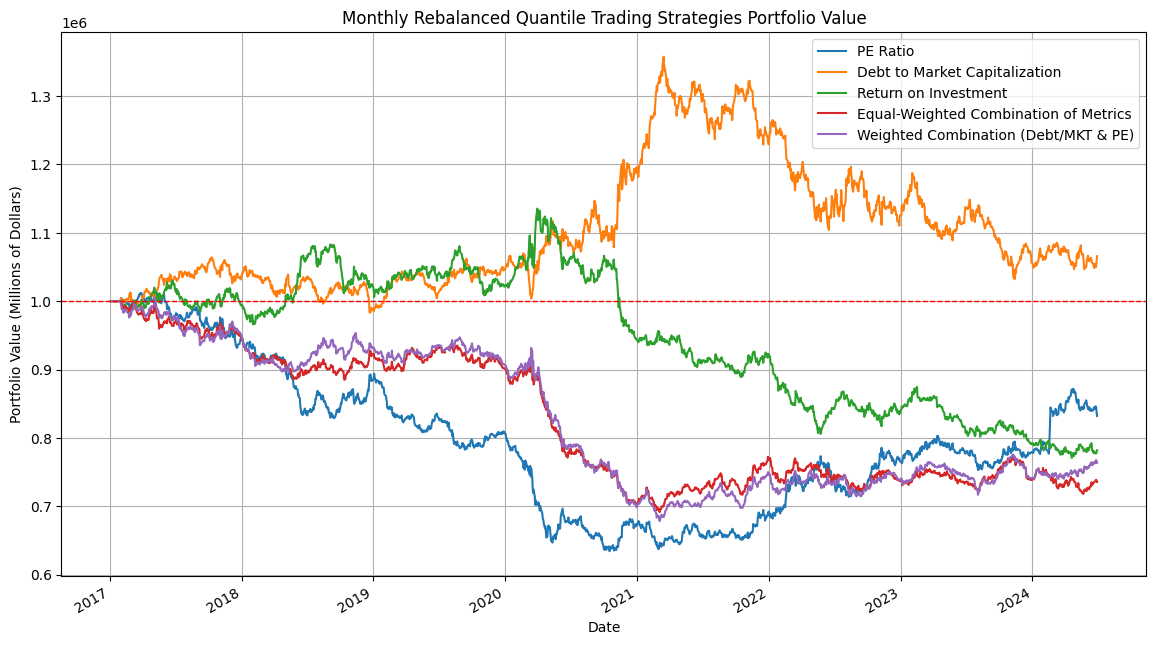

In [18]:
# Plotting the results for monthly strategies
fig, ax = plt.subplots(figsize=(14, 8))

# Monthly series
strategy_labels = {
    'PE': 'PE Ratio',
    'Debt/MKT': 'Debt to Market Capitalization',
    'ROI': 'Return on Investment',
    'Equal Weight': 'Equal-Weighted Combination of Metrics',
    'Weighted DtM/PE': 'Weighted Combination (Debt/MKT & PE)',
}

for strategy_name, label in strategy_labels.items():
    strategy_results[strategy_name]['PortfolioValue'].plot(ax=ax, label=label)

# Initial portfolio value line
initial_value = 1_000_000  # 1 million dollars
ax.axhline(y=initial_value, color='red', linestyle='--', linewidth=1)

ax.set_title('Monthly Rebalanced Quantile Trading Strategies Portfolio Value')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (Millions of Dollars)')
ax.legend()
ax.grid(True)  # Add grid lines

plt.show()


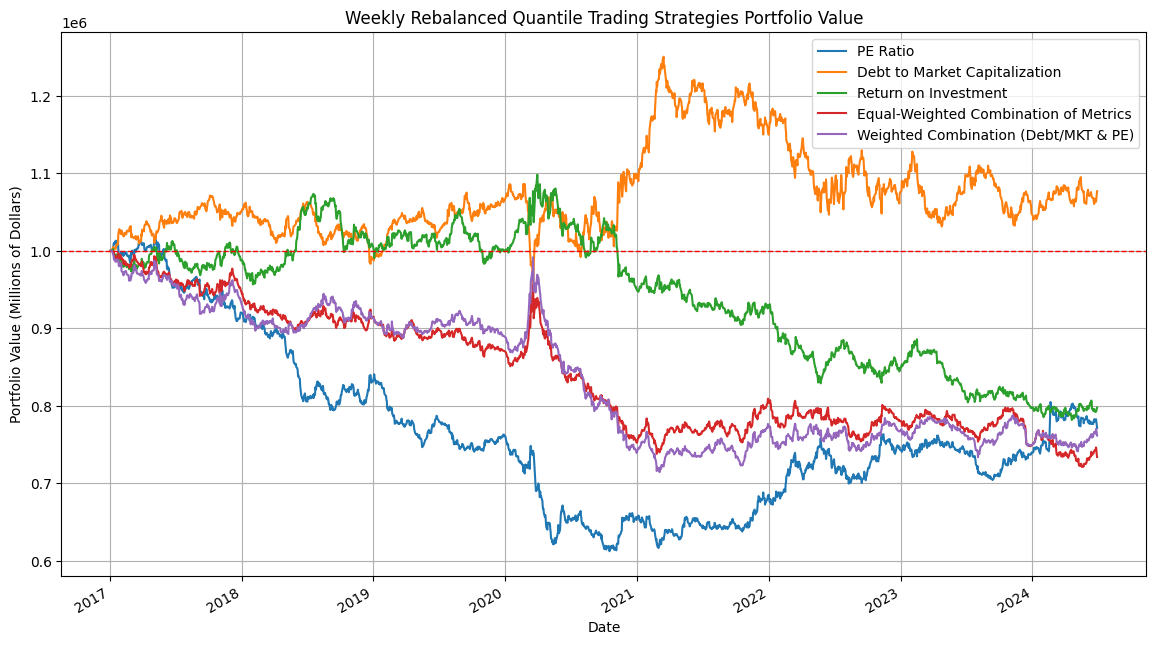

In [19]:
# Plotting the results for weekly strategies
fig, ax = plt.subplots(figsize=(14, 8))

# Weekly series
strategy_labels_weekly = {
    'PE W': 'PE Ratio',
    'Debt/MKT W': 'Debt to Market Capitalization',
    'ROI W': 'Return on Investment',
    'Equal Weight W': 'Equal-Weighted Combination of Metrics',
    'Weighted DtM/PE W': 'Weighted Combination (Debt/MKT & PE)',
}

for strategy_name, label in strategy_labels_weekly.items():
    strategy_results[strategy_name]['PortfolioValue'].plot(ax=ax, label=label)

# Initial portfolio value line
initial_value = 1_000_000  # 1 million dollars
ax.axhline(y=initial_value, color='red', linestyle='--', linewidth=1)

ax.set_title('Weekly Rebalanced Quantile Trading Strategies Portfolio Value')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (Millions of Dollars)')
ax.legend()
ax.grid(True)  # Add grid lines

plt.show()


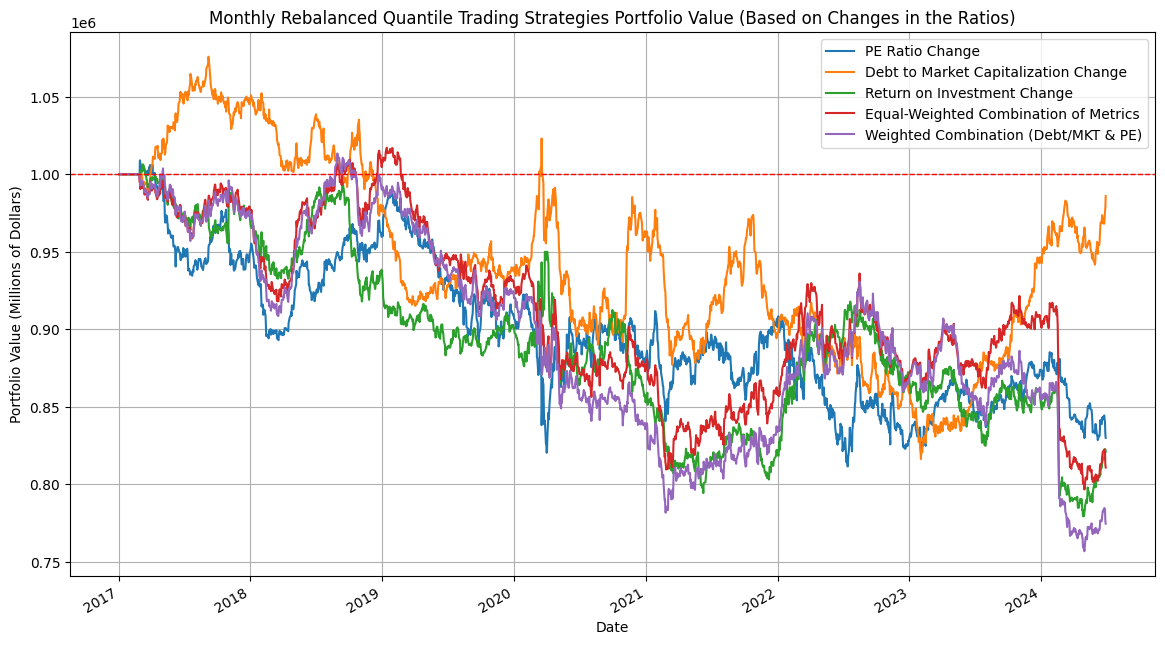

In [20]:
# Plotting the results for monthly strategies using signals_change
fig, ax = plt.subplots(figsize=(14, 8))

# Monthly series with changes
strategy_labels_change = {
    'PE Change': 'PE Ratio Change',
    'Debt/MKT Change': 'Debt to Market Capitalization Change',
    'ROI Change': 'Return on Investment Change',
    'Equal Weight Change': 'Equal-Weighted Combination of Metrics',
    'Weighted DtM/PE Change': 'Weighted Combination (Debt/MKT & PE)',
}

for strategy_name, label in strategy_labels_change.items():
    strategy_results[strategy_name]['PortfolioValue'].plot(ax=ax, label=label)

# Initial portfolio value line
initial_value = 1_000_000  # 1 million dollars
ax.axhline(y=initial_value, color='red', linestyle='--', linewidth=1)

ax.set_title('Monthly Rebalanced Quantile Trading Strategies Portfolio Value (Based on Changes in the Ratios)')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (Millions of Dollars)')
ax.legend()
ax.grid(True)  # Add grid lines

plt.show()

## Strategy with sizing
- I vary the size of the trade for the top and bottom quartile. I put 2.5x weight on the top decile, and 0.5x weight on the bottom decile. 
- Our return improves substantially. However, note that our results basically look like the market and this is because our short positions are very small. So most a lot of the variation can be explained by its correlation to the market. 
- We can see that we have very large Beta and Downside Beta values, in the 60-80 range. Which is why we see this positive return, but with extremely high correlation to the market given by the daily SP500 returns. 

In [21]:
# Now, analyze the strategies when we put more weight to the top quantile and bottom quantiles
# Define the strategies
strategies = {
    'PE': signals_PE,
    'Debt/MKT': signals_DtM,
    'ROI': signals_ROI,
    'Equal Weight': signals_equal_weight,
    'Weighted DtM/PE': signals_weighted_DtM_PE,

    'PE W': signals_PE_W,
    'Debt/MKT W': signals_DtM_W,
    'ROI W': signals_ROI_W,
    'Equal Weight W': signals_equal_weight_W,
    'Weighted DtM/PE W': signals_weighted_DtM_PE_W,

    'PE Change': signals_PE_change,
    'Debt/MKT Change': signals_DtM_change,
    'ROI Change': signals_ROI_change,
    'Equal Weight Change': signals_equal_weight_change,
    'Weighted DtM/PE Change': signals_weighted_DtM_PE_change,
}

# Initialize a dictionary to store performance results
performance_results = {}
strategy_results = {}

# Loop through each strategy and run the backtest
for strategy_name, signals in strategies.items():
    backtest_results, backtest_performance = quantiles_backtest(
        signals=signals,
        original_data=trading_ratios,
        initial_capital=1_000_000,
        annual_funding_rate=0.02,
        short_cost_bps=100.0,
        leverage_factor=1.0,
        trading_days=252,
        sizing_top=2.5,
        sizing_bottom=0.5,
        rf_rate=rf_rate['libor'],
        spy_returns=spy['adj_close'].pct_change().fillna(0)
    )
    performance_results[strategy_name] = backtest_performance
    strategy_results[strategy_name] = backtest_results
    
# Convert the performance results to a DataFrame
performance_df = pd.DataFrame(performance_results).T
performance_df

,Total Return,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown,Beta,Downside Beta,Skewness,Excess Kurtosis,95% VaR,95% CVaR,VaR/Volatility,Sortino Ratio,Treynor Ratio
PE,0.88218,0.07878,0.17491,0.45039,-0.43720,0.66030,0.77859,0.03737,25.17605,-0.01489,-0.02444,0.08512,0.57147,0.11931
Debt/MKT,1.26172,0.10963,0.20789,0.52733,-0.34507,0.84653,0.81834,0.15549,8.60509,-0.01965,-0.02938,0.09452,0.73184,0.12950
ROI,0.79028,0.06968,0.16076,0.43347,-0.30375,0.72809,0.69550,0.13605,12.24999,-0.01535,-0.02278,0.09547,0.58831,0.09571
Equal Weight,0.67598,0.05804,0.14194,0.40887,-0.28793,0.64725,0.65117,-0.26157,12.38642,-0.01275,-0.02087,0.08982,0.52916,0.08967
Weighted DtM/PE,0.74288,0.06288,0.13912,0.45199,-0.29076,0.63780,0.65410,-0.35559,13.00401,-0.01251,-0.02029,0.08993,0.58122,0.09859
PE W,0.75164,0.06875,0.17268,0.39815,-0.43730,0.64535,0.74455,0.19981,23.92326,-0.01491,-0.02422,0.08634,0.51750,0.10654
Debt/MKT W,1.20709,0.10783,0.21448,0.50275,-0.43572,0.86995,0.88126,-0.21576,10.39239,-0.01916,-0.03045,0.08932,0.66535,0.12395
ROI W,0.81785,0.07133,0.15832,0.45058,-0.28884,0.71957,0.67520,0.18082,10.26551,-0.01485,-0.02262,0.09380,0.62073,0.09913
Equal Weight W,0.60235,0.05163,0.13929,0.37064,-0.25453,0.63256,0.60525,0.14961,12.16756,-0.01261,-0.02026,0.09049,0.50155,0.08162
Weighted DtM/PE W,0.76915,0.06420,0.13420,0.47837,-0.22087,0.61646,0.60475,-0.15762,9.04872,-0.01278,-0.01948,0.09521,0.64365,0.10414


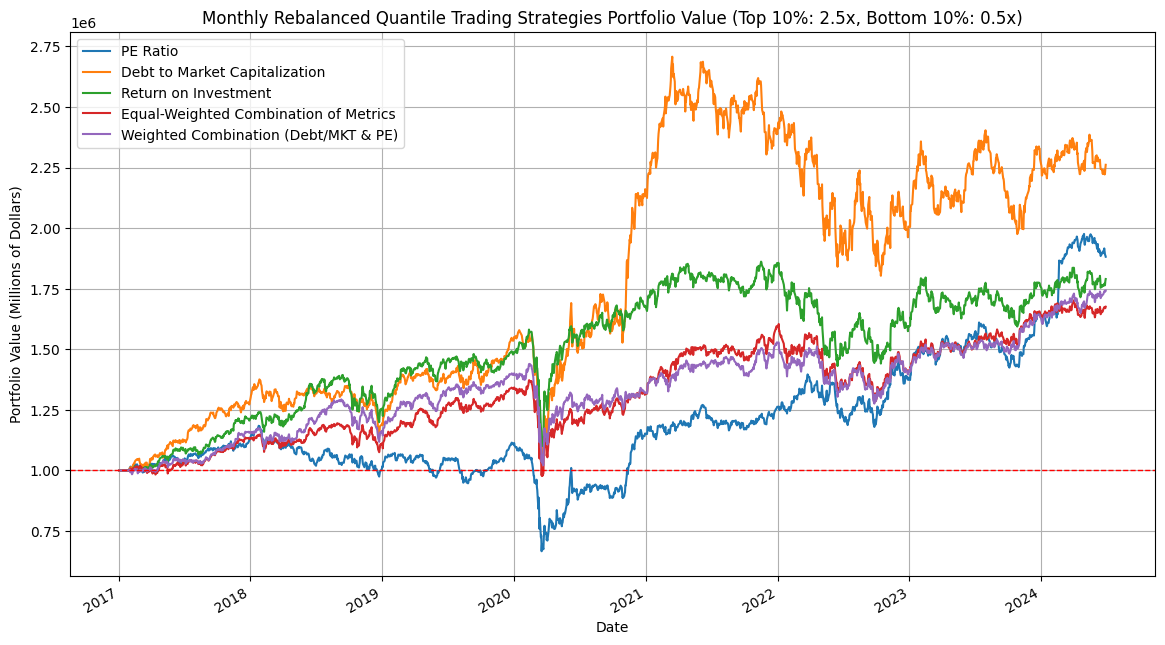

In [22]:
# Plotting the results for monthly strategies
fig, ax = plt.subplots(figsize=(14, 8))

# Monthly series
strategy_labels = {
    'PE': 'PE Ratio',
    'Debt/MKT': 'Debt to Market Capitalization',
    'ROI': 'Return on Investment',
    'Equal Weight': 'Equal-Weighted Combination of Metrics',
    'Weighted DtM/PE': 'Weighted Combination (Debt/MKT & PE)',
}

for strategy_name, label in strategy_labels.items():
    strategy_results[strategy_name]['PortfolioValue'].plot(ax=ax, label=label)

# Initial portfolio value line
initial_value = 1_000_000  # 1 million dollars
ax.axhline(y=initial_value, color='red', linestyle='--', linewidth=1)

ax.set_title('Monthly Rebalanced Quantile Trading Strategies Portfolio Value (Top 10%: 2.5x, Bottom 10%: 0.5x)')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (Millions of Dollars)')
ax.legend()
ax.grid(True)  # Add grid lines

plt.show()

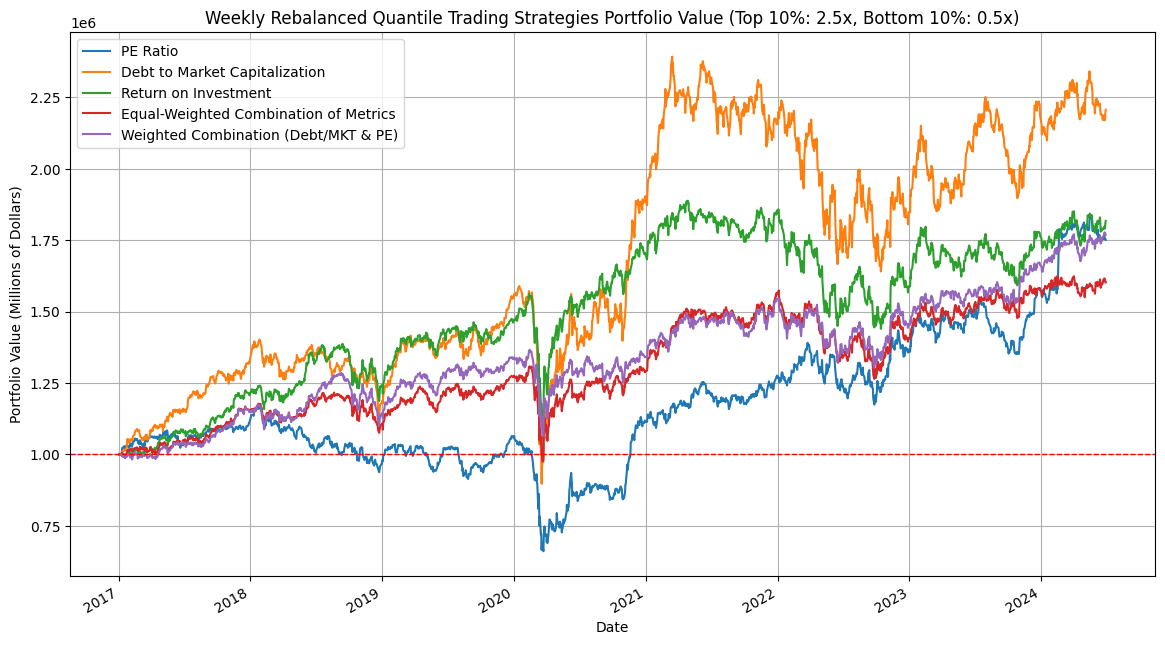

In [23]:
# Plotting the results for weekly strategies
fig, ax = plt.subplots(figsize=(14, 8))

# Weekly series
strategy_labels_weekly = {
    'PE W': 'PE Ratio',
    'Debt/MKT W': 'Debt to Market Capitalization',
    'ROI W': 'Return on Investment',
    'Equal Weight W': 'Equal-Weighted Combination of Metrics',
    'Weighted DtM/PE W': 'Weighted Combination (Debt/MKT & PE)',
}

for strategy_name, label in strategy_labels_weekly.items():
    strategy_results[strategy_name]['PortfolioValue'].plot(ax=ax, label=label)

# Initial portfolio value line
initial_value = 1_000_000  # 1 million dollars
ax.axhline(y=initial_value, color='red', linestyle='--', linewidth=1)

ax.set_title('Weekly Rebalanced Quantile Trading Strategies Portfolio Value (Top 10%: 2.5x, Bottom 10%: 0.5x)')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (Millions of Dollars)')
ax.legend()
ax.grid(True)  # Add grid lines

plt.show()

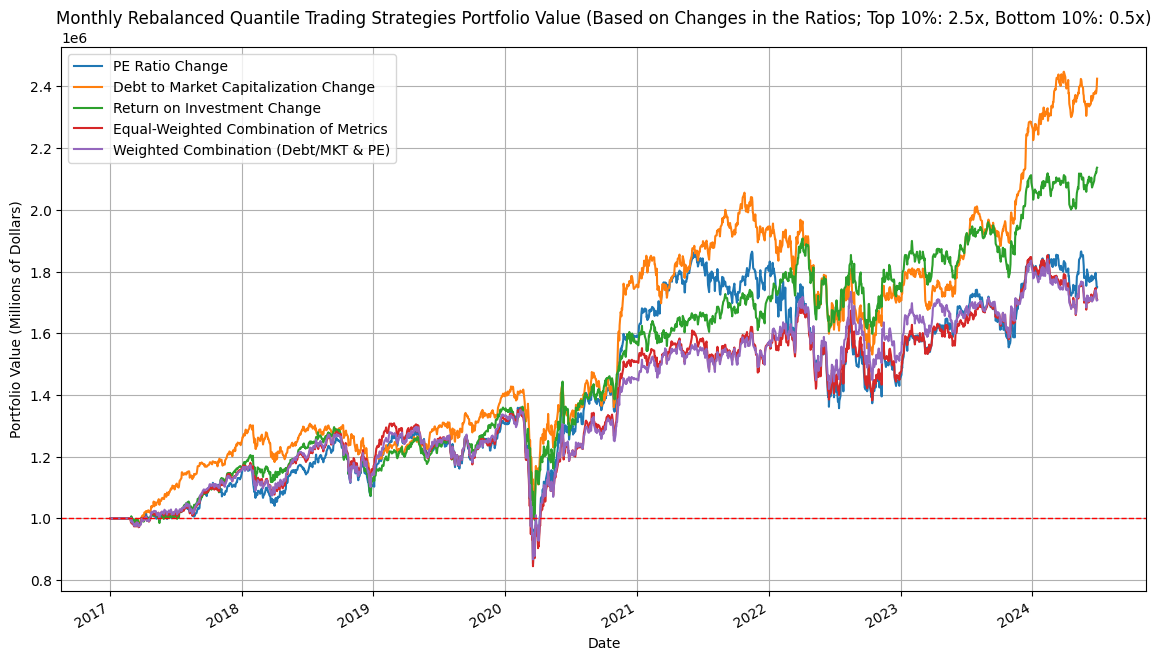

In [24]:
# Plotting the results for monthly strategies using signals_change
fig, ax = plt.subplots(figsize=(14, 8))

# Monthly series with changes
strategy_labels_change = {
    'PE Change': 'PE Ratio Change',
    'Debt/MKT Change': 'Debt to Market Capitalization Change',
    'ROI Change': 'Return on Investment Change',
    'Equal Weight Change': 'Equal-Weighted Combination of Metrics',
    'Weighted DtM/PE Change': 'Weighted Combination (Debt/MKT & PE)',
}

for strategy_name, label in strategy_labels_change.items():
    strategy_results[strategy_name]['PortfolioValue'].plot(ax=ax, label=label)

# Initial portfolio value line
initial_value = 1_000_000  # 1 million dollars
ax.axhline(y=initial_value, color='red', linestyle='--', linewidth=1)

ax.set_title('Monthly Rebalanced Quantile Trading Strategies Portfolio Value (Based on Changes in the Ratios; Top 10%: 2.5x, Bottom 10%: 0.5x)')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (Millions of Dollars)')
ax.legend()
ax.grid(True)  # Add grid lines

plt.show()

## Strategy with leverage
- I tested a leveraged strategy with the traditional long-short portfolio to hedge the market risk. I use 5x1 leverage. 
- We can think of this leveraged strategy as a levered 'Smart-Beta' ETF that tries to captures the risk factors associated with our financial ratios. 
- We can see that when things go right, the results are amazing. However, once we start accumulating loses, the we lose our capital very rapidly. 
- The results goes in line with a levered ETF, in which the return in the long term will decay to zero over time when the ETF has high volatility and low mean return
- Leveraged ETFs are complex due to compounding and volatility decay. 

In [25]:
# Define the strategies
strategies = {
    'PE': signals_PE,
    'Debt/MKT': signals_DtM,
    'ROI': signals_ROI,
    'Equal Weight': signals_equal_weight,
    'Weighted DtM/PE': signals_weighted_DtM_PE,

    'PE W': signals_PE_W,
    'Debt/MKT W': signals_DtM_W,
    'ROI W': signals_ROI_W,
    'Equal Weight W': signals_equal_weight_W,
    'Weighted DtM/PE W': signals_weighted_DtM_PE_W,

    'PE Change': signals_PE_change,
    'Debt/MKT Change': signals_DtM_change,
    'ROI Change': signals_ROI_change,
    'Equal Weight Change': signals_equal_weight_change,
    'Weighted DtM/PE Change': signals_weighted_DtM_PE_change,
}

# Initialize a dictionary to store performance results
performance_results = {}
strategy_results = {}

# Loop through each strategy and run the backtest
for strategy_name, signals in strategies.items():
    backtest_results, backtest_performance = quantiles_backtest(
        signals=signals,
        original_data=trading_ratios,
        initial_capital=1_000_000,
        annual_funding_rate=0.02,
        short_cost_bps=100.0,
        leverage_factor=5.0,
        trading_days=252,
        sizing_top=1.0,
        sizing_bottom=1.0,
        rf_rate=rf_rate['libor'],
        spy_returns=spy['adj_close'].pct_change().fillna(0)
    )
    performance_results[strategy_name] = backtest_performance
    strategy_results[strategy_name] = backtest_results
    
# Convert the performance results to a DataFrame
performance_df = pd.DataFrame(performance_results).T
performance_df

,Total Return,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown,Beta,Downside Beta,Skewness,Excess Kurtosis,95% VaR,95% CVaR,VaR/Volatility,Sortino Ratio,Treynor Ratio
PE,-0.74554,-0.12856,0.39506,-0.32541,-0.92059,-0.27269,0.17771,2.56355,43.66818,-0.03628,-0.05070,0.09183,-0.53569,0.47143
Debt/MKT,-0.17537,0.03873,0.41631,0.09302,-0.80040,0.57373,0.37599,0.81296,8.72950,-0.04050,-0.05524,0.09728,0.14832,0.06750
ROI,-0.79113,-0.17457,0.33420,-0.52235,-0.87913,0.09411,-0.21548,-0.00565,4.73300,-0.03314,-0.04828,0.09916,-0.75736,-1.85483
Equal Weight,-0.83346,-0.21791,0.29121,-0.74831,-0.86504,-0.17867,-0.14643,-0.73548,6.51094,-0.02986,-0.04305,0.10255,-1.00285,1.21965
Weighted DtM/PE,-0.80224,-0.19257,0.29888,-0.64431,-0.88186,-0.15272,-0.13244,-0.84957,8.03905,-0.02874,-0.04479,0.09616,-0.83703,1.26093
PE W,-0.82762,-0.17912,0.39848,-0.44950,-0.93498,-0.39781,-0.14234,2.41972,42.38849,-0.03633,-0.05175,0.09117,-0.73054,0.45025
Debt/MKT W,-0.17547,0.04741,0.43692,0.10851,-0.69749,0.62292,0.54801,0.80823,9.67441,-0.04149,-0.05962,0.09495,0.16758,0.07611
ROI W,-0.76923,-0.16120,0.33473,-0.48156,-0.84651,0.05065,-0.29650,0.15826,4.83020,-0.03196,-0.04699,0.09549,-0.72181,-3.18270
Equal Weight W,-0.84002,-0.21858,0.30827,-0.70906,-0.85307,-0.31881,-0.57708,0.06176,6.52429,-0.03043,-0.04369,0.09870,-1.03169,0.68562
Weighted DtM/PE W,-0.80929,-0.19350,0.31312,-0.61797,-0.84656,-0.31223,-0.53784,-0.05332,8.21449,-0.03004,-0.04554,0.09594,-0.86031,0.61972


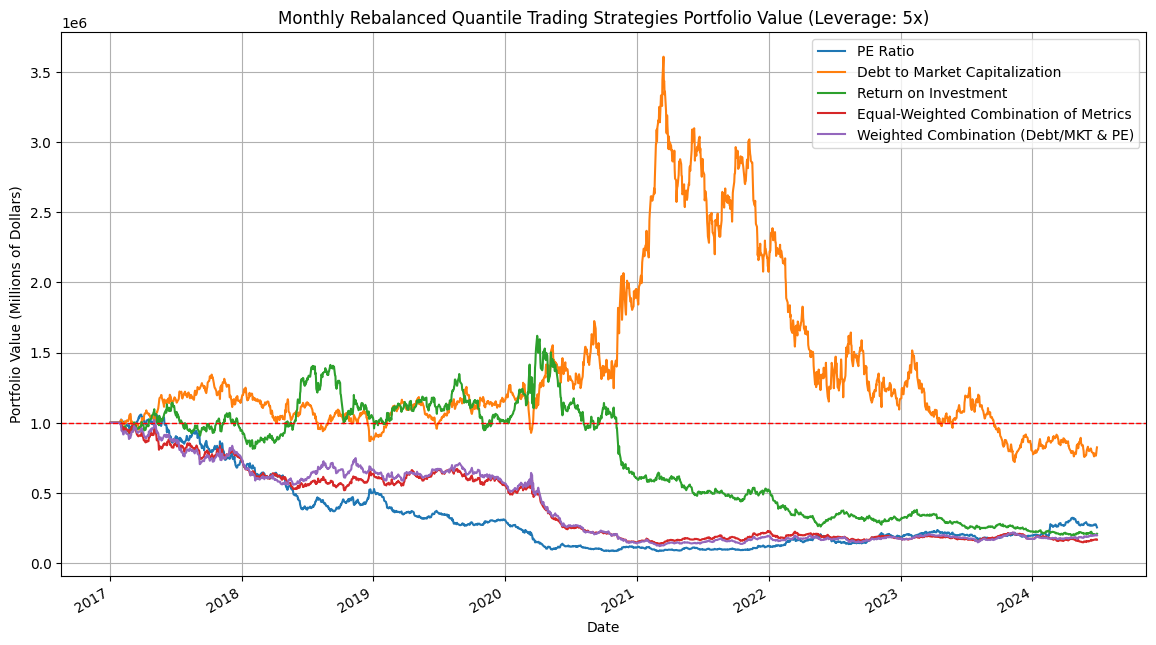

In [26]:
# Plotting the results for monthly strategies
fig, ax = plt.subplots(figsize=(14, 8))

# Monthly series
strategy_labels = {
    'PE': 'PE Ratio',
    'Debt/MKT': 'Debt to Market Capitalization',
    'ROI': 'Return on Investment',
    'Equal Weight': 'Equal-Weighted Combination of Metrics',
    'Weighted DtM/PE': 'Weighted Combination (Debt/MKT & PE)',
}

for strategy_name, label in strategy_labels.items():
    strategy_results[strategy_name]['PortfolioValue'].plot(ax=ax, label=label)

# Initial portfolio value line
initial_value = 1_000_000  # 1 million dollars
ax.axhline(y=initial_value, color='red', linestyle='--', linewidth=1)

ax.set_title('Monthly Rebalanced Quantile Trading Strategies Portfolio Value (Leverage: 5x)')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (Millions of Dollars)')
ax.legend()
ax.grid(True)  # Add grid lines

plt.show()

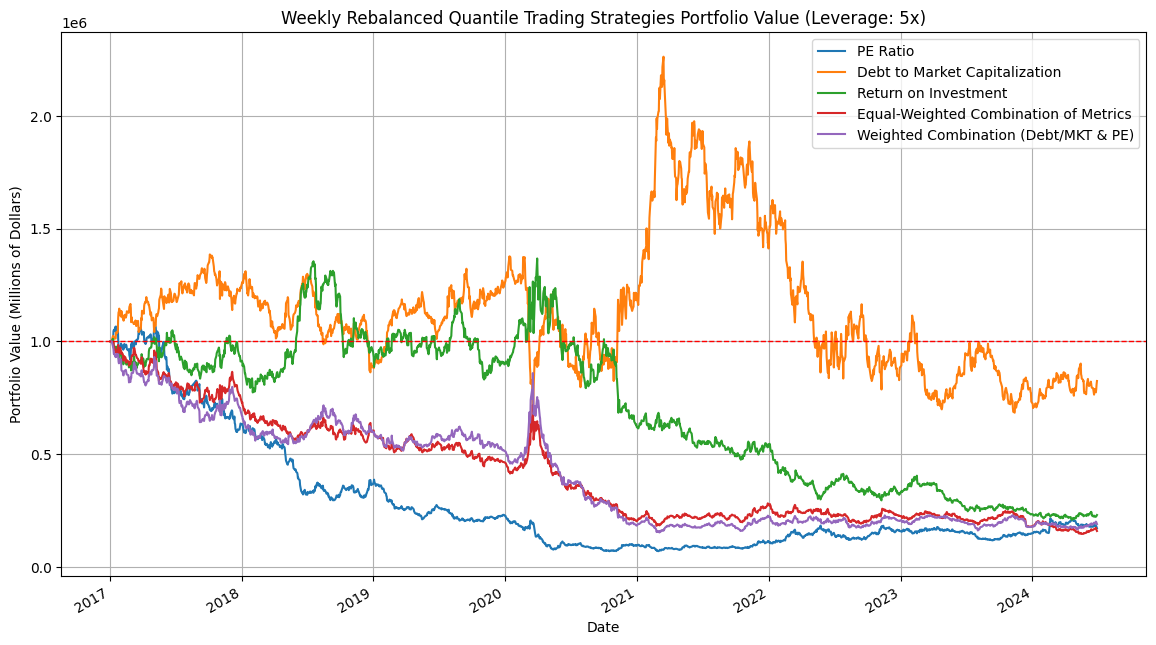

In [27]:
# Plotting the results for weekly strategies
fig, ax = plt.subplots(figsize=(14, 8))

# Weekly series
strategy_labels_weekly = {
    'PE W': 'PE Ratio',
    'Debt/MKT W': 'Debt to Market Capitalization',
    'ROI W': 'Return on Investment',
    'Equal Weight W': 'Equal-Weighted Combination of Metrics',
    'Weighted DtM/PE W': 'Weighted Combination (Debt/MKT & PE)',
}

for strategy_name, label in strategy_labels_weekly.items():
    strategy_results[strategy_name]['PortfolioValue'].plot(ax=ax, label=label)

# Initial portfolio value line
initial_value = 1_000_000  # 1 million dollars
ax.axhline(y=initial_value, color='red', linestyle='--', linewidth=1)

ax.set_title('Weekly Rebalanced Quantile Trading Strategies Portfolio Value (Leverage: 5x)')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (Millions of Dollars)')
ax.legend()
ax.grid(True)  # Add grid lines

plt.show()

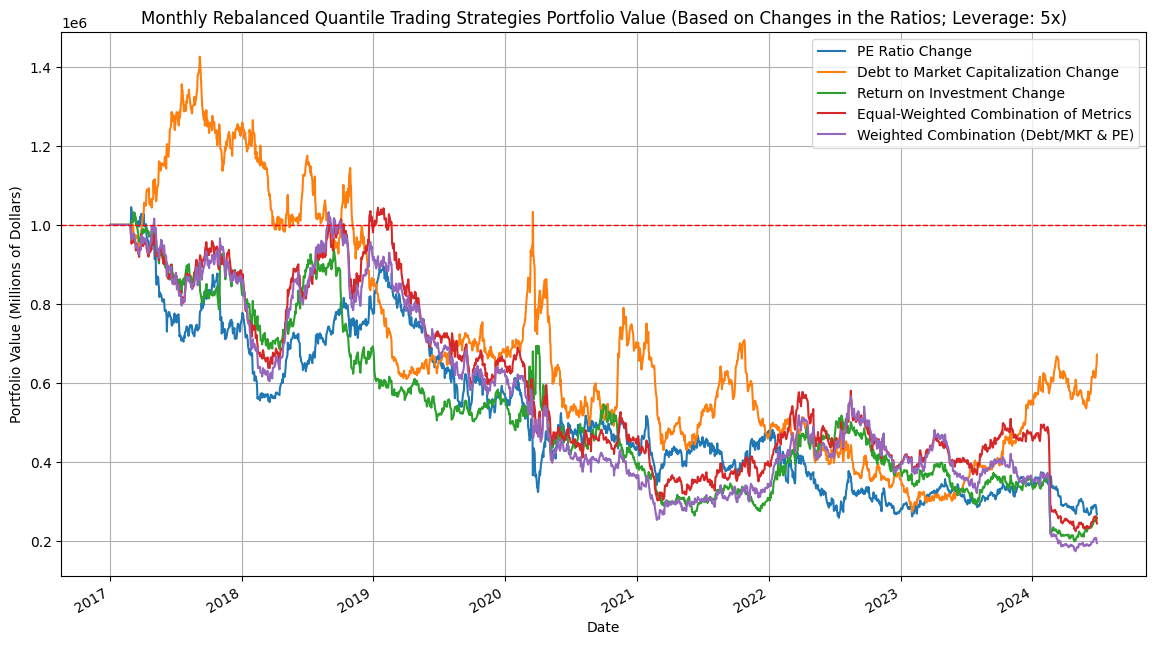

In [28]:
# Plotting the results for monthly strategies using signals_change
fig, ax = plt.subplots(figsize=(14, 8))

# Monthly series with changes
strategy_labels_change = {
    'PE Change': 'PE Ratio Change',
    'Debt/MKT Change': 'Debt to Market Capitalization Change',
    'ROI Change': 'Return on Investment Change',
    'Equal Weight Change': 'Equal-Weighted Combination of Metrics',
    'Weighted DtM/PE Change': 'Weighted Combination (Debt/MKT & PE)',
}

for strategy_name, label in strategy_labels_change.items():
    strategy_results[strategy_name]['PortfolioValue'].plot(ax=ax, label=label)

# Initial portfolio value line
initial_value = 1_000_000  # 1 million dollars
ax.axhline(y=initial_value, color='red', linestyle='--', linewidth=1)

ax.set_title('Monthly Rebalanced Quantile Trading Strategies Portfolio Value (Based on Changes in the Ratios; Leverage: 5x)')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (Millions of Dollars)')
ax.legend()
ax.grid(True)  # Add grid lines

plt.show()

### Conclusion

- The quantile trading strategy did not produce the desired results. 
- The strategy that produced positive returns, and positive Sharpe Ratio was a weighted position that put 2.5x in the long position, and 0.5x in the short position. This of course, generated a strategy that is unhedged and very correlated with the market performance. 
- The leveraged strategy behaves as a leveraged 'Smart Beta' ETF. But given the structure of a leveraged ETF, the volatility decay, and the compounding, this strategy returned extremely poor results losing most of the money at the end of the trading period. 